# Reference
https://www.kaggle.com/code/parhammostame/construct-3d-arrays-from-dcm-nii-3-view-angles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
import gc
from glob import glob
import random
import re
import gzip
import pickle

from tqdm import tqdm

import pydicom as dicom
import nibabel as nib

In [2]:
RESOL = 128
# Order 1: Bowel, 2: left kidney, 3: right kidney, 4: liver, 5: spleen
MASK_ORDER = [5, 3, 4, 1, 2]

BASE_PATH = '/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection'
MASK_SAVE_PATH = f'{BASE_PATH}/mask_preprocessed'

if not os.path.isdir(MASK_SAVE_PATH):
    os.mkdir(MASK_SAVE_PATH)

In [3]:
def compress(name, data):
    with gzip.open(name, 'wb') as f:
        pickle.dump(data, f)

def decompress(name):
    with gzip.open(name, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle(name, data):
    with open(name, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data    

In [4]:
img_list = glob(f'{BASE_PATH}/train_images/*/*')
series_to_patient_dict = {}

for i in range(0, len(img_list)):
    tmp = img_list[i].split('/')
    series_to_patient_dict[int(tmp[-1])] = int(tmp[-2])

seg_path_list = glob(f'{BASE_PATH}/segmentations/*')
seg_info_arr = np.zeros((len(seg_path_list), 2), int)
for i in range(0, len(seg_path_list)):
    series  = int(seg_path_list[i].split('/')[-1][:-4])
    patient = series_to_patient_dict[series]
    seg_info_arr[i,0] = patient
    seg_info_arr[i,1] = series

seg_info_df = pd.DataFrame(seg_info_arr, columns = ['patient_id', 'series'])
seg_info_df['mask_path'] = ''
mask_paths = []
for i in range(0, len(seg_info_df)):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series = row['series']
    mask_paths.append(f'{MASK_SAVE_PATH}/{patient_id}_{series}.pkl')
seg_info_df['mask_path'] = mask_paths

In [5]:
def create_3D_segmentations(filepath, downsample_rate=2):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = np.flip(img, 0)

    if(len(img)>256):
        img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    else:
        img = img[:,::downsample_rate, ::downsample_rate]
    return img

def img_to_masks(img, mask_order  = MASK_ORDER):
    imgs_stack = []    
    for i in range(0, len(mask_order)):
        one_mask = (img==mask_order[i]).astype(np.uint8)
        imgs_stack.append(one_mask[None])

    imgs_stack = np.vstack(imgs_stack)    
    return imgs_stack

def resize_3d(img, resol = RESOL):
    imgs_stack = []
    for i in range(0, len(img)):
        imgs_stack.append(cv2.resize(img[i], (resol, resol))[None])
    imgs_stack = np.vstack(imgs_stack)

    resized_img = np.zeros((resol, resol, resol), np.uint8)
    for i in range(0, len(imgs_stack[0,0])):
        resized_img[:,:,i] = cv2.resize(imgs_stack[:,:,i], (resol, resol))
    del imgs_stack
    gc.collect()
    return resized_img

def process_mask(path):
    img_3d = create_3D_segmentations(path)
    img_3d = img_to_masks(img_3d)
    resized_img_3d = np.zeros((len(img_3d), RESOL, RESOL, RESOL), np.uint8)
    for i in range(0, len(MASK_ORDER)):
        resized_img_3d[i] = resize_3d(img_3d[i])
    del img_3d
    gc.collect()
    return resized_img_3d


In [6]:
seg_path_list[i]

'/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection/segmentations/36257.nii'

In [7]:
train_df = pd.read_csv(f'{BASE_PATH}/train_meta.csv')
seg_info_df['img_path'] = ''
img_paths = []
for i in tqdm(range(0, len(seg_info_df))):
    row = seg_info_df.iloc[i]
    patient_id = row['patient_id']
    series     = row['series']
    train_img_path = train_df.loc[(train_df['patient_id']==patient_id)&(train_df['series']==series), 'path']
    img_paths.append(train_img_path.iloc[0])
    

    img_3d = process_mask(seg_path_list[i])
    save_pickle(seg_info_df['mask_path'][i], img_3d)
    del img_3d
    gc.collect()

seg_info_df['img_path'] = img_paths
seg_info_df.to_csv(f'{BASE_PATH}/seg_info.csv', index = False)    


100%|██████████| 206/206 [01:57<00:00,  1.76it/s]


/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection/mask_preprocessed/10937_12039.pkl
/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection/mask_preprocessed/10937_53000.pkl


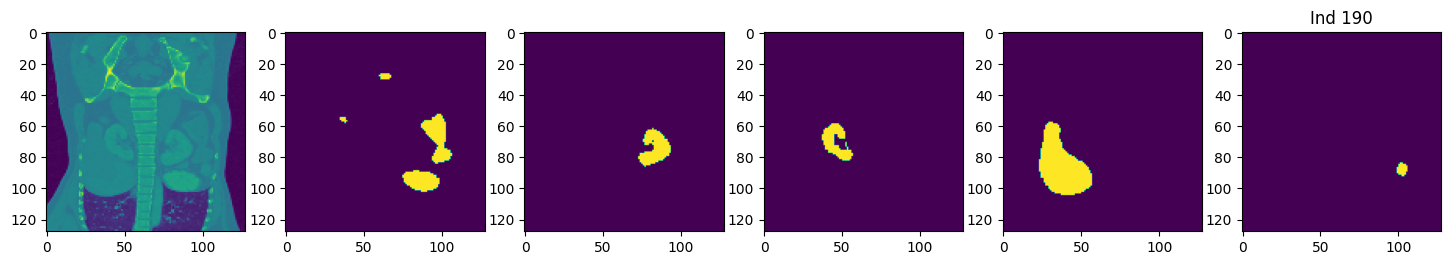

In [8]:
seg_info_df = pd.read_csv(f'{BASE_PATH}/seg_info.csv')

for i in range(0, len(seg_info_df)):
    if (i !=190):
        continue
    row = seg_info_df.iloc[i]
    print(row['mask_path'])
    print(seg_info_df.iloc[202]['mask_path'])
    img_3d = decompress(row['img_path'])
    mask   = load_pickle(row['mask_path'])
    #for j in range(0, 5):
    #    if(np.max(mask[j])==0):
    #        print('zero_region')
    f, axs = plt.subplots(1, 6, figsize=(18, 3))
    plt.title(f'Ind {i}')
    axs[0].imshow(img_3d[:,80,:])
    for j in range(0, 5):
        axs[j+1].imshow(mask[j,:,80,:])
